In [15]:
import time
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV,LassoCV,LassoLarsIC,LinearRegression,RidgeCV
from sklearn.metrics import root_mean_squared_error
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("maize.csv")
df.columns = df.columns.str.replace('"', '').str.strip().str.lower()
df.head()

,geno_code,pop,m1,m2,m3,m4,m5,m6,m7,m8,...,m7382,m7383,m7384,m7385,m7386,m7387,m7388,m7389,entry,dtoa
0,b'Z001E0001',1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,75.5364
1,b'Z001E0002',1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,76.9075
2,b'Z001E0003',1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,75.2646
3,b'Z001E0004',1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,73.6933
4,b'Z001E0005',1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,79.2441


In [3]:
target_col = "dtoa"
marker_cols = [c for c in df.columns if c.startswith("m") and c[1:].isdigit()]

df.dropna(subset=[target_col], inplace=True)

In [4]:
for col in marker_cols:
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].isna().any():
        df[col].fillna(df[col].mean(), inplace=True)

variance = df[marker_cols].var()
zero_var_cols = variance[variance == 0].index
df.drop(columns=zero_var_cols, inplace=True)

In [5]:
marker_cols = [c for c in marker_cols if c not in zero_var_cols]
X = df[marker_cols].copy()
y = df[target_col].copy()

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (4981, 7389), y shape: (4981,)


# Scaling the DataFrame

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Total NaNs in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"Total NaNs in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

Train shape: (3984, 7389), Test shape: (997, 7389)
Total NaNs in X_train_scaled: 0
Total NaNs in X_test_scaled: 0


# Ridge Cross-Validation

In [7]:
print("\nStarting Model 1: Ridge Regression")

alphas = np.logspace(-3, 5, 30)

start_time = time.time()
ridge_model = RidgeCV(alphas=alphas, gcv_mode='svd', store_cv_values=True)
ridge_model.fit(X_train_scaled, y_train)
compute_time = time.time() - start_time

best_alpha = ridge_model.alpha_
coef = ridge_model.coef_

y_pred_train = ridge_model.predict(X_train_scaled)
y_pred_test = ridge_model.predict(X_test_scaled)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
l2_norm = np.linalg.norm(coef, 2)
l1_norm = np.linalg.norm(coef, 1)

best_alpha_index = np.where(ridge_model.alphas == best_alpha)[0][0]
cv_mse = np.mean(ridge_model.cv_values_[:, best_alpha_index])
cv_rmse = np.sqrt(cv_mse)

results_ridge = {
    "Method": "Ridge",
    "RMSE (CV)": cv_rmse,
    "RMSE (Test)": rmse_test,
    "# Feats / Comps": X_train_scaled.shape[1],
    "Time (s)": compute_time
}

print(f"Best alpha: {best_alpha:.6f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE:  {rmse_test:.4f}")
print(f"L2 norm:    {l2_norm:.4f}")
print(f"L1 norm:    {l1_norm:.4f}")
print(results_ridge)



Starting Model 1: Ridge Regression
Best alpha: 100000.000000
Train RMSE: 3.4877
Test RMSE:  3.5436
L2 norm:    0.1079
L1 norm:    7.2203
{'Method': 'Ridge', 'RMSE (CV)': np.float64(3.56521341546775), 'RMSE (Test)': np.float64(3.5436418866585147), '# Feats / Comps': 7389, 'Time (s)': 28.24066472053528}


# Lasso Cross-Validation

In [8]:
print("\nStarting Model 2: Lasso Regression")

start_time = time.time()
lasso_model = LassoCV(n_alphas=50, cv=3, tol=1e-3, random_state=42, n_jobs=-1)
lasso_model.fit(X_train_scaled, y_train)
compute_time = time.time() - start_time

best_alpha = lasso_model.alpha_
coef = lasso_model.coef_

y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_test = lasso_model.predict(X_test_scaled)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
n_selected = np.sum(coef != 0)

best_alpha_index = np.where(lasso_model.alphas_ == best_alpha)[0][0]
cv_mse = lasso_model.mse_path_.mean(axis=1)[best_alpha_index]
cv_rmse = np.sqrt(cv_mse)

results_lasso = {
    "Method": "Lasso",
    "RMSE (CV)": cv_rmse,
    "RMSE (Test)": rmse_test,
    "# Feats / Comps": n_selected,
    "Time (s)": compute_time
}

print(f"Best alpha: {best_alpha:.6f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE:  {rmse_test:.4f}")
print(f"Nonzero Coeffs: {n_selected} / {X_train_scaled.shape[1]}")
print(results_lasso)



Starting Model 2: Lasso Regression
Best alpha: 0.063973
Train RMSE: 3.4773
Test RMSE:  3.5604
Nonzero Coeffs: 103 / 7389
{'Method': 'Lasso', 'RMSE (CV)': np.float64(3.5713690661318265), 'RMSE (Test)': np.float64(3.560384678734642), '# Feats / Comps': np.int64(103), 'Time (s)': 585.7464809417725}


# Elastic-Net Cross-Validation

In [9]:
print("\nStarting Model 3: Elastic Net")

l1_ratios = [0.1, 0.5, 0.9]
start_time = time.time()

enet_model = ElasticNetCV(
    l1_ratio=l1_ratios, n_alphas=50, cv=3, tol=1e-3,
    random_state=42, n_jobs=-1
)
enet_model.fit(X_train_scaled, y_train)
compute_time = time.time() - start_time

best_alpha = enet_model.alpha_
best_l1_ratio = enet_model.l1_ratio_
coef = enet_model.coef_

y_pred_train = enet_model.predict(X_train_scaled)
y_pred_test = enet_model.predict(X_test_scaled)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
n_selected = np.sum(coef != 0)

results_enet = {
    "Method": "Elastic Net",
    "RMSE (Test)": rmse_test,
    "# Feats / Comps": n_selected,
    "Time (s)": compute_time
}

print(f"Best alpha: {best_alpha:.6f}")
print(f"Best l1_ratio: {best_l1_ratio:.2f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE:  {rmse_test:.4f}")
print(f"Nonzero Coeffs: {n_selected} / {X_train_scaled.shape[1]}")
print(results_enet)



Starting Model 3: Elastic Net
Best alpha: 0.482558
Best l1_ratio: 0.10
Train RMSE: 3.4663
Test RMSE:  3.5565
Nonzero Coeffs: 665 / 7389
{'Method': 'Elastic Net', 'RMSE (Test)': np.float64(3.5564522348273533), '# Feats / Comps': np.int64(665), 'Time (s)': 2437.010596036911}


# Principal Components Regression (PCR)

In [10]:
print("\nStarting Model 4: PCR")

start_time = time.time()

pcr_pipe = Pipeline([('pca', PCA()), ('reg', LinearRegression())])
param_grid = {'pca__n_components': [1, 5, 10, 20, 30, 40, 50, 75, 100]}

pcr_search = GridSearchCV(
    pcr_pipe, param_grid, cv=5,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
pcr_search.fit(X_train_scaled, y_train)
compute_time = time.time() - start_time

best_n = pcr_search.best_params_['pca__n_components']
cv_rmse = -pcr_search.best_score_
y_pred_test = pcr_search.predict(X_test_scaled)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

results_pcr = {
    "Method": "PCR",
    "RMSE (CV)": cv_rmse,
    "RMSE (Test)": test_rmse,
    "# Feats / Comps": best_n,
    "Time (s)": compute_time
}

print(f"Best comps: {best_n}")
print(f"CV RMSE:    {cv_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(results_pcr)



Starting Model 4: PCR
Best comps: 30
CV RMSE:    3.5857
Test RMSE:  3.5561
{'Method': 'PCR', 'RMSE (CV)': np.float64(3.585729921190125), 'RMSE (Test)': np.float64(3.5560529591968746), '# Feats / Comps': 30, 'Time (s)': 27.31803584098816}


# Partial Least Squares (PLS)

In [11]:
print("\nStarting Model 5: PLS")

start_time = time.time()
pls_pipe = Pipeline([('pls', PLSRegression())])
param_grid = {'pls__n_components': [1, 5, 10, 15, 20, 25, 30, 40]}

pls_search = GridSearchCV(
    pls_pipe, param_grid, cv=5,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
pls_search.fit(X_train_scaled, y_train)
compute_time = time.time() - start_time

best_n = pls_search.best_params_['pls__n_components']
cv_rmse = -pls_search.best_score_
y_pred_test = pls_search.predict(X_test_scaled)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

results_pls = {
    "Method": "PLS",
    "RMSE (CV)": cv_rmse,
    "RMSE (Test)": test_rmse,
    "# Feats / Comps": best_n,
    "Time (s)": compute_time
}

print(f"Best comps: {best_n}")
print(f"CV RMSE:    {cv_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(results_pls)



Starting Model 5: PLS
Best comps: 1
CV RMSE:    3.5924
Test RMSE:  3.5673
{'Method': 'PLS', 'RMSE (CV)': np.float64(3.592355494806148), 'RMSE (Test)': np.float64(3.567310719426378), '# Feats / Comps': 1, 'Time (s)': 35.86824679374695}


#  LassoLarsIC (AIC/BIC Selection)

In [12]:
print("\nStarting Model 6: LassoLarsIC")

noise_var = results_ridge['RMSE (CV)'] ** 2

start_time = time.time()
lars_aic = LassoLarsIC(criterion='aic', noise_variance=noise_var)
lars_aic.fit(X_train_scaled, y_train)
time_aic = time.time() - start_time

start_time = time.time()
lars_bic = LassoLarsIC(criterion='bic', noise_variance=noise_var)
lars_bic.fit(X_train_scaled, y_train)
time_bic = time.time() - start_time

y_pred_aic = lars_aic.predict(X_test_scaled)
y_pred_bic = lars_bic.predict(X_test_scaled)
rmse_aic = root_mean_squared_error(y_test, y_pred_aic)
rmse_bic = root_mean_squared_error(y_test, y_pred_bic)
n_aic = np.sum(lars_aic.coef_ != 0)
n_bic = np.sum(lars_bic.coef_ != 0)

results_aic = {
    "Method": "Stepwise (AIC)",
    "RMSE (Test)": rmse_aic,
    "# Feats / Comps": n_aic,
    "Time (s)": time_aic
}
results_bic = {
    "Method": "Stepwise (BIC)",
    "RMSE (Test)": rmse_bic,
    "# Feats / Comps": n_bic,
    "Time (s)": time_bic
}

print(f"AIC RMSE: {rmse_aic:.4f}, Nonzero: {n_aic}, Time: {time_aic:.2f}s")
print(f"BIC RMSE: {rmse_bic:.4f}, Nonzero: {n_bic}, Time: {time_bic:.2f}s")
print(results_aic)
print(results_bic)



Starting Model 6: LassoLarsIC
AIC RMSE: 3.5713, Nonzero: 135, Time: 4.59s
BIC RMSE: 3.5581, Nonzero: 16, Time: 3.66s
{'Method': 'Stepwise (AIC)', 'RMSE (Test)': np.float64(3.571251415222154), '# Feats / Comps': np.int64(135), 'Time (s)': 4.5906970500946045}
{'Method': 'Stepwise (BIC)', 'RMSE (Test)': np.float64(3.5580508754836577), '# Feats / Comps': np.int64(16), 'Time (s)': 3.6617319583892822}


# Results' Visualizations

In [13]:
sns.set_theme(style="whitegrid")

all_results = [
    results_ridge,
    results_lasso,
    results_enet,
    results_pcr,
    results_pls,
    results_aic,
    results_bic
]

df_results = pd.DataFrame(all_results)

df_results = df_results.set_index('Method')


df_results.rename(columns={
    'RMSE (Test)': 'Test RMSE',
    '# Feats / Comps': 'Features / Components',
    'Time (s)': 'Time (seconds)',
    'RMSE (CV)': 'CV RMSE'
}, inplace=True)

if 'CV RMSE' not in df_results.columns:
    df_results['CV RMSE'] = np.nan

df_results = df_results[['CV RMSE', 'Test RMSE', 'Features / Components', 'Time (seconds)']]

display(df_results)

,CV RMSE,Test RMSE,Features / Components,Time (seconds)
Method,,,,
Ridge,3.565213,3.543642,7389,28.240665
Lasso,3.571369,3.560385,103,585.746481
Elastic Net,NaN,3.556452,665,2437.010596
PCR,3.585730,3.556053,30,27.318036
PLS,3.592355,3.567311,1,35.868247
Stepwise (AIC),NaN,3.571251,135,4.590697
Stepwise (BIC),NaN,3.558051,16,3.661732


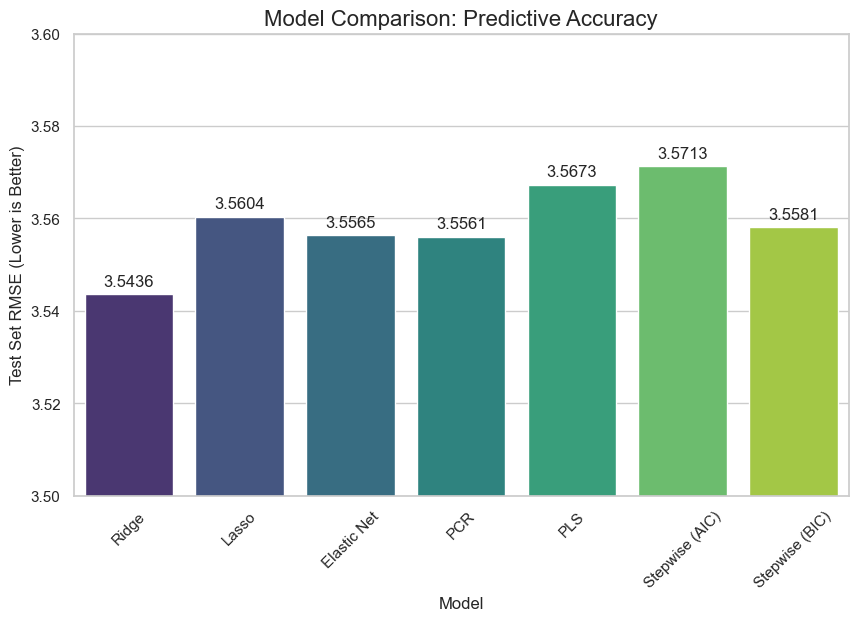

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=df_results.index, 
    y='Test RMSE', 
    data=df_results, 
    palette='viridis'
)
ax.set_ylim(3.5, 3.6)

plt.title('Model Comparison: Predictive Accuracy', fontsize=16)
plt.ylabel('Test Set RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.4f}',
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 9), 
        textcoords='offset points'
    )
    
plt.show()

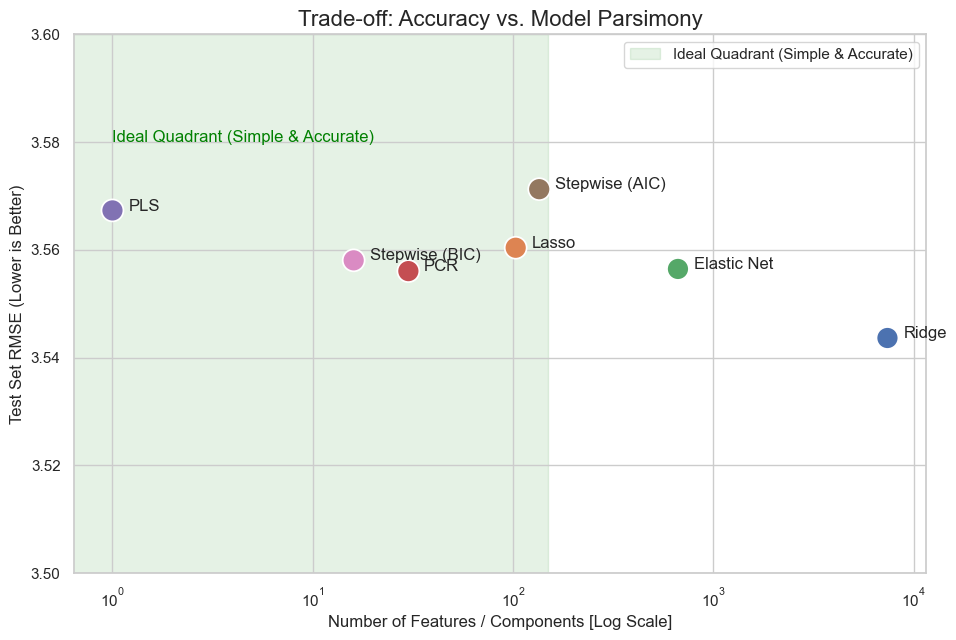

In [19]:
plt.figure(figsize=(11, 7))
ax = sns.scatterplot(
    x='Features / Components',
    y='Test RMSE',
    data=df_results,
    hue=df_results.index,
    s=250,
    legend=False
)

ax.set_xscale('log')
ax.set_ylim(3.5, 3.6)

plt.title('Trade-off: Accuracy vs. Model Parsimony', fontsize=16)
plt.xlabel('Number of Features / Components [Log Scale]')
plt.ylabel('Test Set RMSE (Lower is Better)')

for i in range(df_results.shape[0]):
    plt.text(
        df_results['Features / Components'][i] * 1.2,
        df_results['Test RMSE'][i],
        df_results.index[i],
        horizontalalignment='left',
        fontsize=12
    )

plt.axvspan(0, 150, color='green', alpha=0.1, zorder=0, label='Ideal Quadrant (Simple & Accurate)')
plt.text(1, 3.58, 'Ideal Quadrant (Simple & Accurate)', color='green', fontsize=12)

plt.legend()
plt.show()

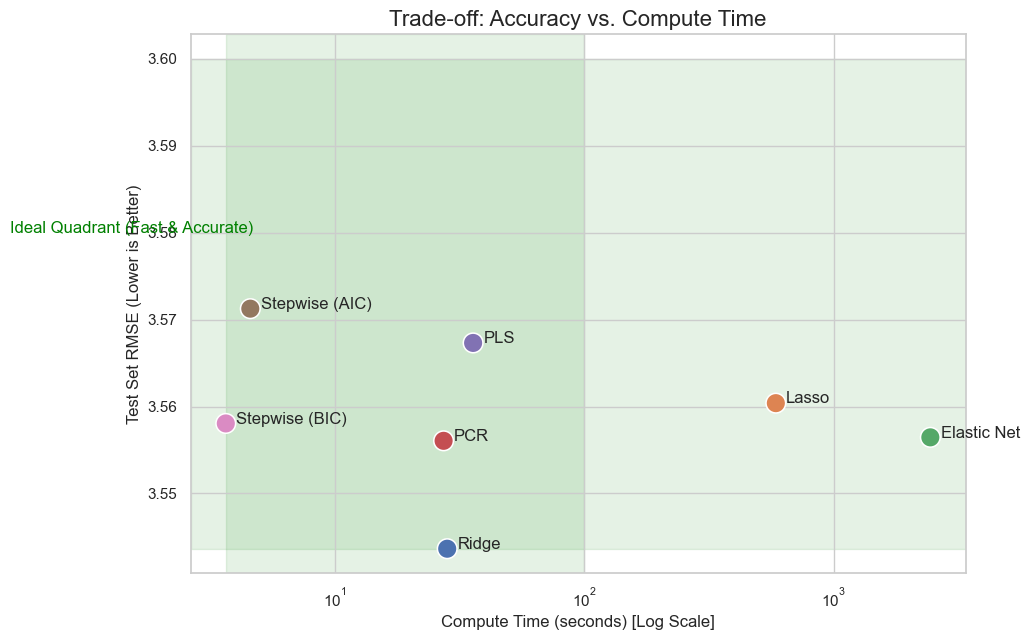

In [20]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    x='Time (seconds)',
    y='Test RMSE',
    data=df_results,
    hue=df_results.index,
    s=200,
    legend=False
)

ax.set_xscale('log')

plt.title('Trade-off: Accuracy vs. Compute Time', fontsize=16)
plt.xlabel('Compute Time (seconds) [Log Scale]')
plt.ylabel('Test Set RMSE (Lower is Better)')

for i in range(df_results.shape[0]):
    plt.text(
        df_results['Time (seconds)'][i] * 1.1,
        df_results['Test RMSE'][i],
        df_results.index[i],
        horizontalalignment='left'
    )

ax.axvspan(df_results['Time (seconds)'].min(), 100, color='green', alpha=0.1, zorder=0)
ax.axhspan(df_results['Test RMSE'].min(), 3.6, color='green', alpha=0.1, zorder=0)
plt.text(0.5, 3.58, 'Ideal Quadrant (Fast & Accurate)', color='green', fontsize=12)

plt.show()